# 2.8 Validación de Modelos  
Proyecto: Retail Sales Dataset

En este notebook validamos los dos modelos supervisados desarrollados previamente:

- **Regresión Lineal** (para predecir un valor continuo)
- **Regresión Logística** (para clasificar clientes HighSpender)

Este proceso sigue el mismo enfoque visto en clase:
- BostonHousing → Métricas de regresión (RMSE, MAE, R²)
- BankNote → Métricas de clasificación (Accuracy, Precision, Recall, F1, AUC)

El objetivo es evaluar la calidad de ambos modelos y determinar cómo se comportan al aplicarlos en el contexto del negocio retail.


In [1]:
# Importamos las librerías necesarias para modelos, métricas y gráficas.

import pandas as pd        # Manejo de dataframes
import numpy as np         # Operaciones numéricas

# Herramientas para separar datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split

# Modelos supervisados: Regresión Lineal y Logística
from sklearn.linear_model import LinearRegression, LogisticRegression

# Métricas para regresión y clasificación
from sklearn.metrics import (
    mean_squared_error,   # Error cuadrático medio
    mean_absolute_error,  # Error absoluto medio
    r2_score,             # R² para regresión
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)

import matplotlib.pyplot as plt  # Gráficos
import seaborn as sns            # Gráficos avanzados


## 1. Carga del Dataset Escalado

Utilizamos el archivo:

**`retail_sales_escalado_standard.csv`**

Este archivo contiene:
- Variables numéricas normalizadas (muy importante para modelos supervisados)
- Columnas limpias y sin valores nulos
- Transformaciones ya aplicadas (edad, cantidad, precio, monto total escalado)

Este dataset es suficiente para reconstruir ambos modelos desde cero
(es decir, no necesitamos cargar archivos .pkl ni modelos guardados).


In [2]:
# Cargar dataset escalado (StandardScaler)
df = pd.read_csv("retail_sales_escalado_standard.csv")

# Mostrar primeras filas para verificar que cargó correctamente
df.head()


,edad_std,cantidad_std,precio_unitario_std,monto_total_std
0,-0.540565,0.429265,-0.685123,-0.546704
1,-1.125592,-0.453996,1.688464,0.971919
2,0.629489,-1.337258,-0.790615,-0.761098
3,-0.321180,-1.337258,1.688464,0.078611
4,-0.833078,-0.453996,-0.685123,-0.636035


## 2. Creación de la Variable Objetivo (HighSpender)

Para validar el modelo de clasificación (Regresión Logística) necesitamos una columna binaria.

La creamos así:

- HighSpender = 1 → Cliente cuyo gasto (monto_total_std) es mayor a la mediana.
- HighSpender = 0 → Cliente cuyo gasto es igual o menor a la mediana.

Este método imita la lógica vista en clase donde convertimos un valor continuo en una clase binaria.


In [3]:
# Creamos la variable HighSpender comparando la columna escalada monto_total_std
df["HighSpender"] = (df["monto_total_std"] > df["monto_total_std"].median()).astype(int)

# Revisamos cuántos 0 y cuántos 1 hay en el dataset
df["HighSpender"].value_counts()


HighSpender
1    500
0    500
Name: count, dtype: int64

# A) VALIDACIÓN DEL MODELO DE REGRESIÓN LINEAL

El objetivo de la regresión lineal es **predecir un valor continuo**, en este caso:

`monto_total_std`

Las métricas correctas para validarlo son:

### ✔ RMSE — Error cuadrático medio  
Indica qué tan lejos están las predicciones del valor real.

### ✔ MAE — Error absoluto medio  
Promedio de cuánto se equivoca el modelo en cada predicción.

### ✔ R² — Varianza explicada  
Qué porcentaje del comportamiento del gasto puede explicar el modelo.


In [4]:
# Variables predictoras para regresión lineal
X_lin = df[["edad_std", "cantidad_std", "precio_unitario_std"]]

# Variable objetivo continua
y_lin = df["monto_total_std"]

# Dividimos entre entrenamiento y prueba (70/30)
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(
    X_lin, y_lin, test_size=0.3, random_state=42
)


In [5]:
# Creamos el modelo
modelo_lin = LinearRegression()

# Entrenamos el modelo con los datos de entrenamiento
modelo_lin.fit(X_train_lin, y_train_lin)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [ ]:
# Predicciones sobre el conjunto de prueba
y_pred_lin = modelo_lin.predict(X_test_lin)

# Calculamos las métricas
rmse = np.sqrt(mean_squared_error(y_test_lin, y_pred_lin))  
mae = mean_absolute_error(y_test_lin, y_pred_lin)         
r2 = r2_score(y_test_lin, y_pred_lin)                  

rmse, mae, r2


(np.float64(0.36022640629374253), 0.30572534821861236, 0.8545690523836659)

## 2.5.2 Comparación de Valores Reales vs Valores Predichos

Para evaluar visualmente qué tan bien funciona el modelo de **Regresión Lineal**, se generó una gráfica que compara:

- Los **valores reales** del monto total estandarizado (`monto_total_std`)
- Contra los **valores predichos** por el modelo

Esta gráfica permite ver si el modelo aprendió correctamente la relación entre las variables de entrada y el monto total.




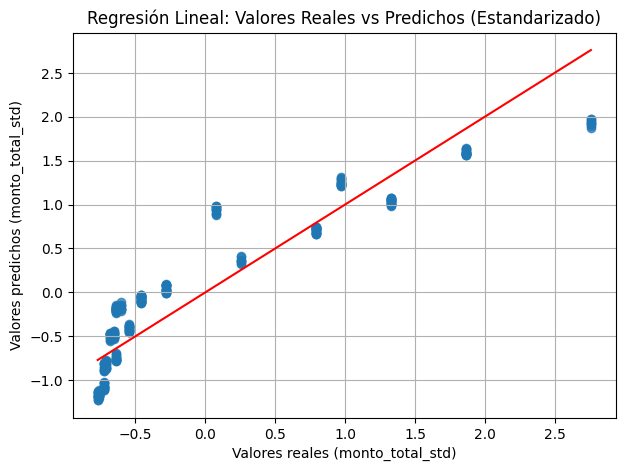

In [7]:
# Gráfica de Valores Reales vs Predichos (Regresión Lineal)

plt.figure(figsize=(7,5))
plt.scatter(y_test_lin, y_pred_lin, alpha=0.7)
plt.plot(
    [min(y_test_lin), max(y_test_lin)],
    [min(y_test_lin), max(y_test_lin)],
    "r"
)
plt.title("Regresión Lineal: Valores Reales vs Predichos (Estandarizado)")
plt.xlabel("Valores reales (monto_total_std)")
plt.ylabel("Valores predichos (monto_total_std)")
plt.grid(True)
plt.show()


### Interpretación de las métricas de Regresión Lineal

- **RMSE:** Qué tanto se desvía la predicción promedio del valor real.  
- **MAE:** Error promedio por predicción.  
- **R²:** Qué porcentaje del comportamiento del gasto puede explicar el modelo.

Un buen modelo tiene:
- RMSE bajo
- MAE bajo
- R² cercano a 1


🟥 B) VALIDACIÓN DE REGRESIÓN LOGÍSTICA

## 4. Validación del Modelo de Regresión Logística

Este modelo clasifica a los clientes como:

- 1 = HighSpender
- 0 = LowSpender

Las métricas correctas para la validación son:

- Accuracy → qué porcentaje acertó  
- Precision → qué tan confiable es cuando predice "HighSpender"  
- Recall → qué tan bien encuentra a los HighSpender reales  
- F1-score → equilibrio entre Precision y Recall  
- Matriz de Confusión  
- Curva ROC – AUC  


In [8]:
# Variables predictoras (numéricas escaladas)
X_log = df[["edad_std", "cantidad_std", "precio_unitario_std"]]

# Variable objetivo binaria
y_log = df["HighSpender"]

# División en train/test estratificada
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_log, y_log, test_size=0.3, stratify=y_log, random_state=42
)


In [9]:
modelo_log = LogisticRegression(max_iter=1000)
modelo_log.fit(X_train_log, y_train_log)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [10]:
# Predicciones en el conjunto de prueba
y_pred_log = modelo_log.predict(X_test_log)

# Cálculo de métricas
accuracy = accuracy_score(y_test_log, y_pred_log)
precision = precision_score(y_test_log, y_pred_log)
recall = recall_score(y_test_log, y_pred_log)
f1 = f1_score(y_test_log, y_pred_log)

accuracy, precision, recall, f1


(0.9766666666666667, 1.0, 0.9533333333333334, 0.9761092150170648)

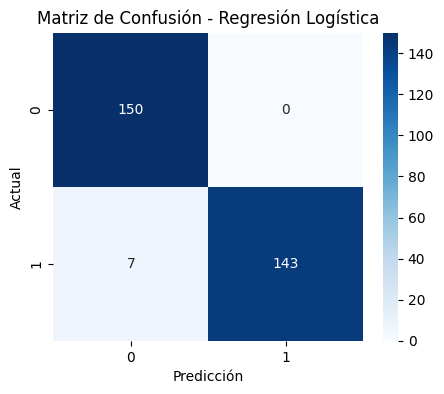

In [11]:
mat = confusion_matrix(y_test_log, y_pred_log)

plt.figure(figsize=(5,4))
sns.heatmap(mat, annot=True, cmap="Blues", fmt="d")
plt.title("Matriz de Confusión - Regresión Logística")
plt.xlabel("Predicción")
plt.ylabel("Actual")
plt.show()


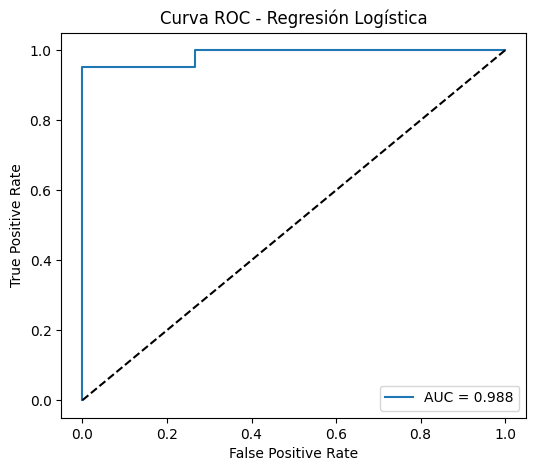

In [12]:
# Probabilidad de que cada muestra sea HighSpender
y_prob = modelo_log.predict_proba(X_test_log)[:, 1]

# Cálculo de puntos ROC
fpr, tpr, _ = roc_curve(y_test_log, y_prob)
roc_auc = auc(fpr, tpr)

# Gráfica
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], "k--")
plt.title("Curva ROC - Regresión Logística")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# 5. Conclusiones de la Validación de Modelos

## ✔ Regresión Lineal (predice gasto total)
- RMSE y MAE muestran qué tan cerca está la predicción del valor real.
- R² indica qué tanto del gasto puede explicarse con variables como edad, cantidad y precio.
- Es útil para **predicción del monto de compra** y **proyecciones de ventas**.

## ✔ Regresión Logística (clasifica HighSpender)
- Accuracy mide aciertos generales.
- Precision indica qué tan correcto es el modelo cuando predice HighSpender.
- Recall indica qué tan bien identifica HighSpenders reales.
- AUC resume la capacidad para distinguir entre clases.
- Es ideal para **segmentación de clientes** y **marketing dirigido**.

## ✔ Conclusión empresarial
Ambos modelos son útiles para distintas áreas del negocio:

- La **Regresión Lineal** ayuda a planear inventario, ingresos y prever demanda.
- La **Regresión Logística** permite identificar clientes valiosos y crear campañas estratégicas.

Ambos modelos se complementan y fortalecen la toma de decisiones dentro de la empresa retail.
